## Sparklink demo 

In this demo we de-duplicate a small dataset.

The purpose is to provide an end-to-end example of how to use the package

I print the output at each stage using `spark_dataframe.show()`.  This massively degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [2]:
import logging 
logging.basicConfig()

# Set to DEBUG if you want sparklink to log the SQL statements it's executing under the hood
logging.getLogger("sparklink").setLevel(logging.INFO)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf=SparkConf()
conf.set('spark.driver.memory', '8g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Step 2:  Read in data and create comparisons using blocking rules

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



In [5]:
blocking_rules = [
    'l.first_name = r.first_name',
    'l.surname = r.surname',
    'l.dob = r.dob'
]

In [6]:
from sparklink.blocking import block_using_rules
df_comparison = block_using_rules(df, blocking_rules, spark=spark)
df_comparison.show(5)

# For small datasets, you can use a cartesian join - df_comparison = cartestian_block(df, df.columns, spark=spark)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+---------+--------------------+-------------------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|   city_r|             email_l|            email_r|group_l|group_r|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+---------+--------------------+-------------------+-------+-------+
|          0|          3|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-10-29|London|     null| hannah88@powers.com| hannah88opowersc@m|      0|      0|
|          0|          1|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-07-31|London|   London| hannah88@powers.com|hannah88@powers.com|      0|      0|
|          5|        637|       Noah |       Noah |   Watson|   Gibson|2008-03-23|1987-07-20|Bolton|   London|matthew78@ballard...|  avazquec@bnks.zom|      1| 

## Step 3:  Compute Fellegi Sunter comparison vectors from the table of comparisons

In [7]:
from sparklink.gammas import add_gammas

gamma_settings = {
    "first_name": {
        "levels": 3
    },
    "surname": {
        "levels": 3
    },
    "dob": {
        "levels": 2
    },
    "city": {
        "levels": 2
    },
    "email": {
        "levels": 2
    }
}


df_gammas = add_gammas(df_comparison, gamma_settings, spark, include_orig_cols = True)
df_gammas.persist()
df_gammas.show(5)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+---------+--------------------+-------------------+-------+-------+-------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|   city_r|             email_l|            email_r|gamma_0|gamma_1|gamma_2|gamma_3|gamma_4|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+---------+--------------------+-------------------+-------+-------+-------+-------+-------+
|          0|          3|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-10-29|London|     null| hannah88@powers.com| hannah88opowersc@m|      2|     -1|      1|     -1|      0|
|          0|          1|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-07-31|London|   London| hannah88@powers.com|hannah88@powers.com|      2|     -1|      0|      1|      1|
|          5|        637|       Noah |  

## Step 4:  Set initial values for parameters of Fellegi Sunter model (the m and u probabilities)

In [8]:
from sparklink.params import Params 
params = Params(gamma_settings, starting_lambda=0.5)

In [9]:
#  Note that the params object has a formatted, human-readable __repr__ representation when you print it
params

λ (proportion of matches) = 0.5
------------------------------------
gamma_0: Comparison of first_name

Probability distribution of gamma values amongst matches:
    value 0: 0.100000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.700000 (level represents highest category of string similarity)

Probability distribution of gamma values amongst non-matches:
    value 0: 0.700000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.100000 (level represents highest category of string similarity)
------------------------------------
gamma_1: Comparison of surname

Probability distribution of gamma values amongst matches:
    value 0: 0.100000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.700000 (level represents highest category of string similarity)

Probability distribution of gamma values amongst non-matches:
    value 0: 0.700000 (level represents lowes

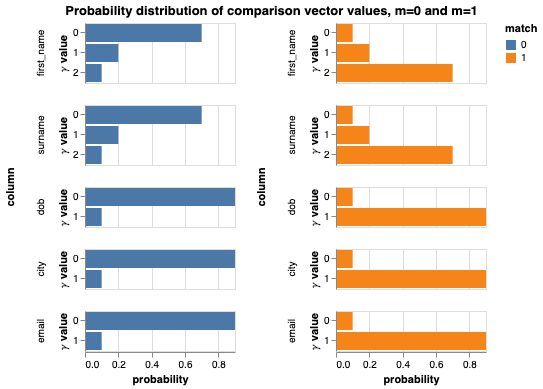

In [10]:
# Note there are various graphical representations of the information contained in parameters, such as:
params.probability_distribution_chart()

## Step 5:  Repeatedly apply expectation and maximisation step to improve parameter estimates

In [11]:
from sparklink.iterate import iterate
logging.getLogger("sparklink").setLevel(logging.INFO)
df_e = iterate(df_gammas, spark, params, num_iterations=20, compute_ll=True)

INFO:sparklink.expectation_step:
Log likelihood for iteration 0:  -22022.170996069908

INFO:sparklink.expectation_step:
Log likelihood for iteration 1:  -15746.24022948742

INFO:sparklink.expectation_step:
Log likelihood for iteration 2:  -15521.784611105919

INFO:sparklink.expectation_step:
Log likelihood for iteration 3:  -15474.522659540176

INFO:sparklink.expectation_step:
Log likelihood for iteration 4:  -15458.776454925537

INFO:sparklink.expectation_step:
Log likelihood for iteration 5:  -15450.697553277016

INFO:sparklink.expectation_step:
Log likelihood for iteration 6:  -15445.675500750542

INFO:sparklink.expectation_step:
Log likelihood for iteration 7:  -15442.159262657166

INFO:sparklink.expectation_step:
Log likelihood for iteration 8:  -15439.608337163925

INFO:sparklink.expectation_step:
Log likelihood for iteration 9:  -15437.720843076706

INFO:sparklink.expectation_step:
Log likelihood for iteration 10:  -15436.233827471733

INFO:sparklink.expectation_step:
Log likeli

## Step 6: Inspect results 



In [12]:
# Inspect main dataframe that contains the match scores
df_e.toPandas().sample(5)

,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability
758,71,72,Isabella,Isabella,Cooper,Cooper,1987-11-18,1987-11-18,Stockton-on-Tees,Stockton-on-Tees,imoore@turner-gonzalez.info,imoore@turner-gonzalez.info,2,2,1,1,1,0.48735401034355164000,0.47899198532104490,0.6847820281982422000,0.49587100744247437,0.011895000003278255,0.79593002796173100,0.14225199818611145,0.67918002605438230,0.011711999773979187,0.68514299392700200,0.999886
372,142,749,Harry,Michael,Taylor,Taylor,2017-11-24,1993-06-23,London,Brighton,coltonray@lee.com,rhmndawilliams@gnzalez-scott.coo,0,2,0,0,0,0.51226699352264400000,0.43492001295089720,0.6847820281982422000,0.49587100744247437,0.988104999065399200,0.20407000184059143,0.85774797201156620,0.32082000374794006,0.988287985324859600,0.31485700607299805,0.009902
2346,681,721,Sienna,Sienna,Daies,Taylor,2016-01-10,2005-06-04,Plymouth,Liverpool,heather69@martin-bradford.biz,javierfrederick@kelly.org,2,0,0,0,0,0.48735401034355164000,0.47899198532104490,0.3137150108814239500,0.43201300501823425,0.988104999065399200,0.20407000184059143,0.85774797201156620,0.32082000374794006,0.988287985324859600,0.31485700607299805,0.021550
895,508,629,Alfie,Alfie,None,None,2005-06-20,2015-02-05,London,London,michellejackson@smith-trujillo.com,garciarichard@brady.com,2,-1,0,1,0,0.48735401034355164000,0.47899198532104490,1.0000000000000000000,1.00000000000000000,0.988104999065399200,0.20407000184059143,0.14225199818611145,0.67918002605438230,0.988287985324859600,0.31485700607299805,0.169516
1293,781,783,Moh medm,Mohammed,Patel,Patel,1989-03-19,1989-05-06,Sheffield,Sheffield,he3ther1@cabrera-reed.com,heather31@cabrera-reed.com,0,2,0,1,0,0.51226699352264400000,0.43492001295089720,0.6847820281982422000,0.49587100744247437,0.988104999065399200,0.20407000184059143,0.14225199818611145,0.67918002605438230,0.988287985324859600,0.31485700607299805,0.113237


Note that the `params` object is updated during the process of iteration.

This means that if we inspect it again, we will see a new set of parameters - those that result from the application of the expectation maximiastion algorithm

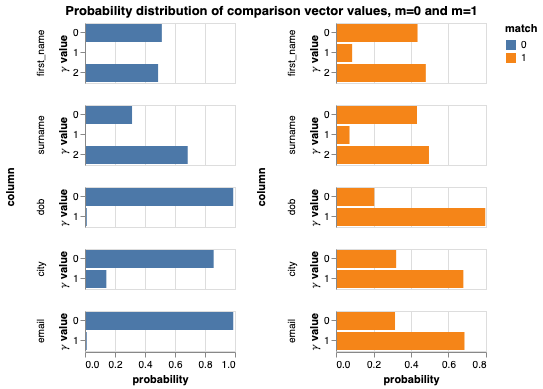

In [13]:
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

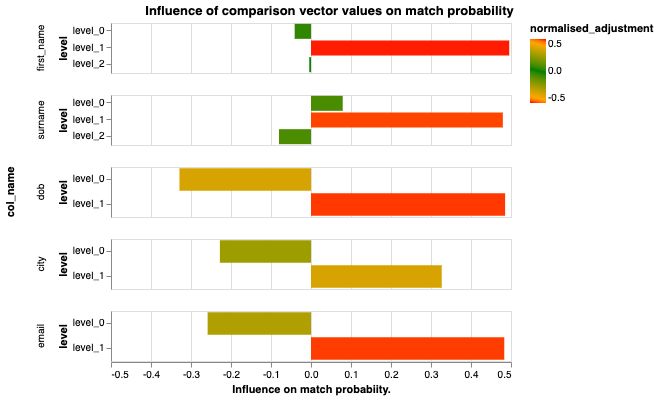

In [14]:
params.adjustment_factor_chart()

In [15]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default sparklink_charts.html)
params.all_charts_write_html_file()

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [21]:
from sparklink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.3979940116405487

Comparison of first_name.  Values are:
first_name_l: Ethan 
first_name_r: Isabelle 
Comparison has 3 levels
𝛾 for this comparison = gamma_0 = 0
Amongst matches, P(𝛾 = 0.4349200129508972):
Amongst non matches, P(𝛾 = 0.512266993522644):
Adjustment factor = p1/(p1 + p2) = 0.45917016384139586
New probability of match (updated belief): 0.3595047630703848

Comparison of surname.  Values are:
surname_l: Brown
surname_r: Brown
Comparison has 3 levels
𝛾 for this comparison = gamma_1 = 2
Amongst matches, P(𝛾 = 0.49587100744247437):
Amongst non matches, P(𝛾 = 0.6847820281982422):
Adjustment factor = p1/(p1 + p2) = 0.4199972324412609
New probability of match (updated belief): 0.2889890542039875

Comparison of dob.  Values are:
dob_l: 2010-12-22
dob_r: 1979-01-22
Comparison has 2 levels
𝛾 for this comparison = gamma_2 = 0
Amongst matches, P(𝛾 = 0.20407000184059143):
Amongst non matches, P(𝛾 = 0.9881049990653992):
Adjustment factor = p1

## Step 7: Term frequency adjustments

Sparklink enables you to make adjustments for term frequency on any number of columns

This enables match probabilities to be adjusted for e.g. the fact John Smith is more prevalent than Robin Linacre

In [22]:
from sparklink.term_frequencies import make_adjustment_for_term_frequencies
df_e_adj = make_adjustment_for_term_frequencies(df_e, params, ["first_name", "surname"], retain_adjustment_columns=True, spark=spark)

In [23]:
pdtf = df_e_adj.toPandas()
sam = pdtf.sample(10)
sam[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

,match_probability,tf_adjusted_match_prob,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability,first_name_adj,surname_adj,tf_adjusted_match_prob
3723,0.974067,0.974064,930,932,ahoTs,Thomas,None,Mills,1970-03-09,1970-03-09,None,London,hensondebbie@garcia.com,None,0,-1,1,-1,-1,0.51226699352264400000,0.43492001295089720,1.0000000000000000000,1.00000000000000000,0.011895000003278255,0.79593002796173100,1.00000000000000000,1.00000000000000000,1.000000000000000000,1.00000000000000000,0.974067,0.500000,0.500000,0.974064
5146,0.011644,0.002130,93,135,None,None,Jones,Jones,2003-11-25,1980-06-23,Brighton,Lnoon,samuel91@curry.info,trobinson@garza.com,-1,2,0,0,0,1.00000000000000000000,1.00000000000000000,0.6847820281982422000,0.49587100744247437,0.988104999065399200,0.20407000184059143,0.85774797201156620,0.32082000374794006,0.988287985324859600,0.31485700607299805,0.011644,0.500000,0.153456,0.002130
4386,0.055604,0.017551,153,730,Harry,Harry,Hil,Lawrence,2017-10-23,2016-12-25,None,Stoke-on-ernt,zporter@robinson.com,barbarapace@manning.org,2,0,0,-1,0,0.48735401034355164000,0.47899198532104490,0.3137150108814239500,0.43201300501823425,0.988104999065399200,0.20407000184059143,1.00000000000000000,1.00000000000000000,0.988287985324859600,0.31485700607299805,0.055604,0.232790,0.500000,0.017551
219,0.999865,0.999871,195,202,Jacob,Jacob,Eans,Evans,1987-02-06,1987-02-06,Southend-on-Sea,Southend-on-Sea,None,baorygary@flores.cm,2,1,1,1,-1,0.48735401034355164000,0.47899198532104490,0.0015040000434964895,0.07211600244045258,0.011895000003278255,0.79593002796173100,0.14225199818611145,0.67918002605438230,1.000000000000000000,1.00000000000000000,0.999865,0.513230,0.500000,0.999871
1522,0.009902,0.007313,121,989,Daniel,Sophia,Ellis,Ellis,2013-01-14,1981-10-17,Stoke-on-Trent,Shefield,wmcdaniel@nelson.net,danielle24@garia-jonee.nst,0,2,0,0,0,0.51226699352264400000,0.43492001295089720,0.6847820281982422000,0.49587100744247437,0.988104999065399200,0.20407000184059143,0.85774797201156620,0.32082000374794006,0.988287985324859600,0.31485700607299805,0.009902,0.500000,0.424170,0.007313
5031,0.950852,0.950852,665,669,Taylor,Ivy,Ivy,Taylor,1980-01-13,1980-01-13,London,Lodno,None,jonesjennifer@pitts.com,0,0,1,0,-1,0.51226699352264400000,0.43492001295089720,0.3137150108814239500,0.43201300501823425,0.011895000003278255,0.79593002796173100,0.85774797201156620,0.32082000374794006,1.000000000000000000,1.00000000000000000,0.950852,0.500000,0.500000,0.950852
2495,0.026046,0.005658,515,669,Alfie,Ivy,Taylor,Taylor,2005-06-20,1980-01-13,None,Lodno,michellejackson@smith-trujillo.com,jonesjennifer@pitts.com,0,2,0,-1,0,0.51226699352264400000,0.43492001295089720,0.6847820281982422000,0.49587100744247437,0.988104999065399200,0.20407000184059143,1.00000000000000000,1.00000000000000000,0.988287985324859600,0.31485700607299805,0.026046,0.500000,0.175443,0.005658
5027,0.995959,0.995956,668,671,Taylor,Ivy,Ivy,Taylor,1980-01-13,1980-01-13,London,London,jonesjennifer@pitts.com,None,0,0,1,1,-1,0.51226699352264400000,0.43492001295089720,0.3137150108814239500,0.43201300501823425,0.011895000003278255,0.79593002796173100,0.14225199818611145,0.67918002605438230,1.000000000000000000,1.00000000000000000,0.995959,0.500000,0.500000,0.995956
2522,0.113237,0.026451,142,367,Harry,Nacy,Taylor,Taylor,2017-11-24,1989-07-25,London,London,coltonray@lee.com,wagnershane@landry.com,0,2,0,1,0,0.51226699352264400000,0.43492001295089720,0.6847820281982422000,0.49587100744247437,0.988104999065399200,0.20407000184059143,0.14225199818611145,0.67918002605438230,0.988287985324859600,0.31485700607299805,0.113237,0.500000,0.175443,0.026451
2708,0.009902,0.002124,364,974,Nancy,Reuben,Taylor,Tayl